In [2]:
import os
import geopandas as gpd
import ee, eemont, geemap
import numpy as np
import pandas as pd
from pandas.io.clipboards import read_clipboard
import rasterio as rio
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr
from sklearn import cluster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from datetime import datetime, timedelta

from  py00_model_fucntion import run_full_model

Map = geemap.Map()

In [3]:
# Data sourced from https://catalogue.data.wa.gov.au/dataset/dbca-fire-history - login required to download shapefile

try: 
    fire_history = gpd.read_file('poly_simplified/poly_simplified_output.shp')
except:
    fire_bulk = gpd.read_file('DBCAFireHistoryDBCA_060.zip')
    fire_history = (fire_bulk[(fire_bulk.fih_year1 > 2000) &
                              (fire_bulk['fih_hectar'] > fire_bulk['fih_hectar'].quantile(.90))])

    fire_history.to_file('sample_poly/sample_poly.shp')
    fire_history = gpd.read_file('poly_simplified/poly_simplified_output.shp')

try: 
    main_pandas = pd.read_csv('main_pandas.csv')

except:

    fire_test = fire_history.sort_values('fih_hectar', ascending = False)

    main_run = run_full_model(fire_test)

    main_pandas = pd.concat(main_run)

    os.remove('main_pandas.csv')
    main_pandas.to_csv('main_pandas.csv')

    mean_df = main_pandas.groupby('fire_name').mean().reset_index()

C:\Users\micha\miniconda3\envs\spatial-env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
main_pandas = main_pandas.sort_values('dnbr_class')

main_pandas['dnbr_class'] = main_pandas['dnbr_class'].astype(str)

main_pandas_plt = main_pandas[main_pandas['dnbr_class'].isin(['3','4','5'])]

C:\Users\micha\AppData\Local\Temp/ipykernel_10284/3923499679.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_pandas_plt['class_name'] = np.select(conditions, values)
C:\Users\micha\miniconda3\envs\spatial-env\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\micha\miniconda3\envs\spatial-env\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\micha\miniconda3\envs\spatial-env\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" ca

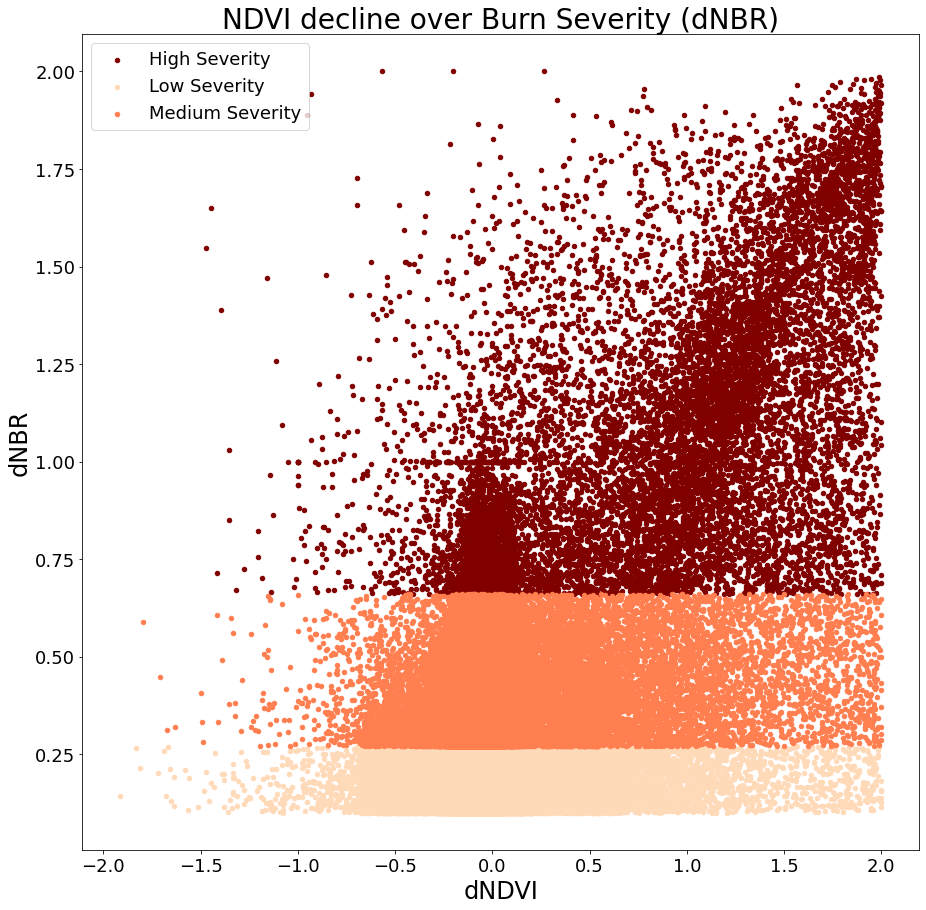

In [5]:
# create a list of our conditions
conditions = [
    (main_pandas_plt['dnbr_class'] == '3'),
    (main_pandas_plt['dnbr_class'] == '4'),
    (main_pandas_plt['dnbr_class'] == '5')
    ]

# create a list of the values we want to assign for each condition
values = ['Low Severity', 'Medium Severity', 'High Severity']

# create a new column and use np.select to assign values to it using our lists as arguments
main_pandas_plt['class_name'] = np.select(conditions, values)

# Plot scatter plot
fig, ax = plt.subplots(figsize=(15, 15))

col = {'Low Severity':'peachpuff', 
       'Medium Severity':'coral', 
       'High Severity':'maroon'}

for label, grp in main_pandas_plt.groupby('class_name'):
    grp.plot('dndvi',
             'dnbr',
             ax = ax,
             kind = 'scatter', 
             color = col[label],
             label = label,
             s = 20, 
             )

ax.legend(fontsize = 18)

ax.set_xlabel('dNDVI', fontsize=24)
ax.set_ylabel('dNBR', fontsize=24)
ax.set_title('NDVI decline over Burn Severity (dNBR)', 
              fontsize = 28)

ax.tick_params(axis = 'both',
               which = 'major', 
               labelsize = 18)

plt.show()

No handles with labels found to put in legend.


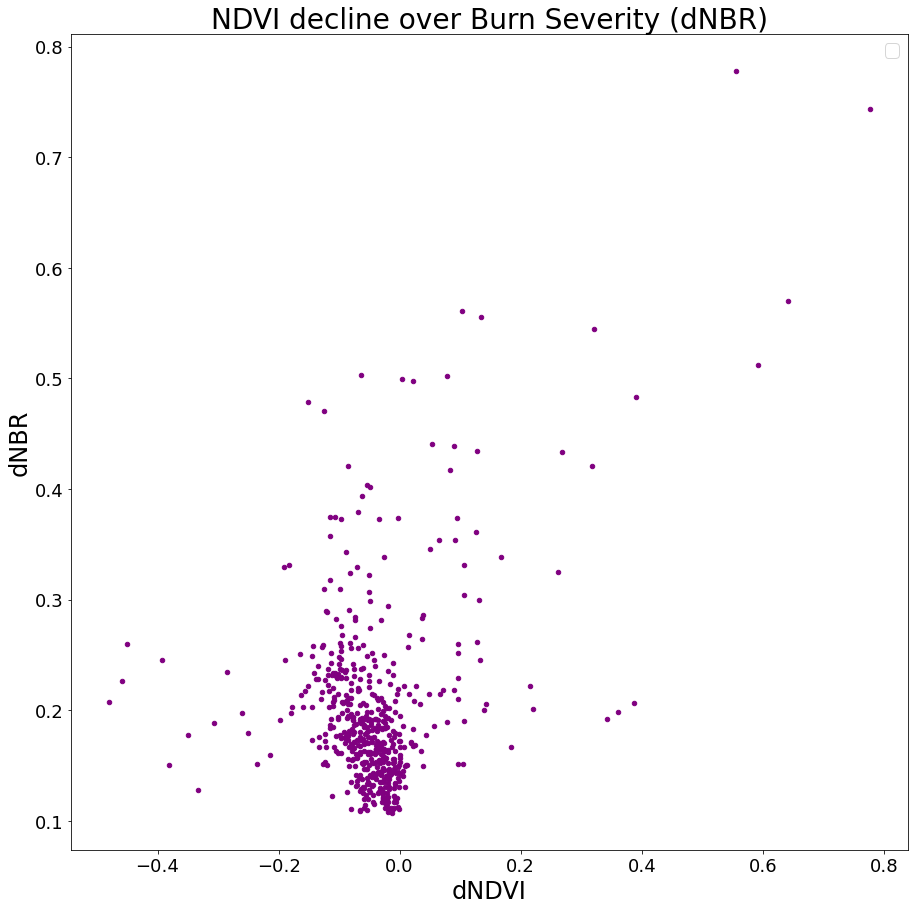

In [6]:
main_pandas_plt_mean = main_pandas_plt.groupby('fire_name').mean()

# Plot scatter plot
fig, ax = plt.subplots(figsize=(15, 15))


main_pandas_plt_mean.plot('dndvi',
                          'dnbr',
                          ax = ax,
                          kind = 'scatter', 
                          color = 'purple',
                          s = 20, 
                          )

ax.legend(fontsize = 18)

ax.set_xlabel('dNDVI', fontsize=24)
ax.set_ylabel('dNBR', fontsize=24)
ax.set_title('NDVI decline over Burn Severity (dNBR)', 
              fontsize = 28)

ax.tick_params(axis = 'both',
               which = 'major', 
               labelsize = 18)

plt.show()

In [7]:
from scipy import stats

main_reg = main_pandas.dropna()

r_lst = []
r2_lst = []
pval_lst = []

for i in main_reg['fire_name'].unique():

    df = main_reg[main_reg['fire_name'] == i]

    x = df['dndvi']
    y = df['dnbr']

    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    except:
        None

    print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

    r_lst.append(r_value)
    r2_lst.append(r_value ** 2)
    pval_lst.append(p_value)

slope: -0.25175460583225207 
intercept: 0.03977923809229754 
r squared: 0.01398287458896112
slope: 0.16985851489366147 
intercept: -0.002766124740571509 
r squared: 0.02306168454599369
slope: 0.48620436295992053 
intercept: 0.0015179384161539515 
r squared: 0.1881309984591005
slope: 0.39425026108917105 
intercept: -0.002377932504681648 
r squared: 0.07785038609404184
slope: 0.3004571117789748 
intercept: 0.06125505086193219 
r squared: 0.04227404086158554
slope: 0.07491078896106511 
intercept: 0.07762479086671768 
r squared: 0.004272353199370782
slope: 0.1474843823673609 
intercept: 0.05724385149334775 
r squared: 0.008402463679397756
slope: 0.062212773192382255 
intercept: 0.11948135805077288 
r squared: 0.0018385002127894337
slope: -0.0007683799156477358 
intercept: 0.06522900699247208 
r squared: 3.9642722405562185e-07
slope: 0.17627819868487704 
intercept: 0.03619881804035597 
r squared: 0.003801871170451563
slope: 0.2733160115210857 
intercept: 0.011366659370830218 
r squared: 0.0

In [ ]:
# Creating plot

fig = plt.figure(figsize = (15, 12))

plt.hist(r2_lst, bins = 100)

ax = plt.gca()

ax.set(title = "Histogram of R2 values for all fire event sites",
               xlabel = "R2",
               ylabel = 'Number of sites') 


ax.set_xlabel('R2', fontsize=18)
ax.set_ylabel('Number of sites', fontsize=18)
ax.set_title('Histogram of R2 values for all fire event sites', fontsize = 24)

ax.tick_params(axis = 'both',
               which = 'major', 
               labelsize = 16)

plt.show()

In [ ]:
main_pandas_plt_3 = main_pandas_plt[main_pandas_plt['dnbr_class'] == '3']

x = main_pandas_plt_3.dropna()['dndvi']
y = main_pandas_plt_3.dropna()['dnbr']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
"\nintercept:", intercept,
"\nr squared:", r_value**2)

In [ ]:
main_pandas_plt_4 = main_pandas_plt[main_pandas_plt['dnbr_class'] == '4']

x = main_pandas_plt_4.dropna()['dndvi']
y = main_pandas_plt_4.dropna()['dnbr']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
"\nintercept:", intercept,
"\nr squared:", r_value**2)

In [ ]:
main_pandas_plt_5 = main_pandas_plt[main_pandas_plt['dnbr_class'] == '5']

x = main_pandas_plt_5.dropna()['dndvi']
y = main_pandas_plt_5.dropna()['dnbr']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
"\nintercept:", intercept,
"\nr squared:", r_value**2)

In [ ]:
# Plot scatter plot
fig, ax = plt.subplots(figsize=(15, 15))

for label, grp in main_pandas_plt_4.groupby('class_name'):
    grp.plot('dndvi',
             'dnbr',
             ax = ax,
             kind = 'scatter', 
             color = col[label],
             label = label,
             s = 20, 
             )

ax.legend(fontsize = 18)

ax.set_xlabel('dNDVI', fontsize=24)
ax.set_ylabel('dNBR', fontsize=24)
ax.set_title('NDVI decline over Burn Severity (dNBR)', 
              fontsize = 28)

ax.tick_params(axis = 'both',
               which = 'major', 
               labelsize = 18)

plt.show()